In [1]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
import warnings
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("../ML Intro Exercises 2/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("../ML Intro Exercises 2/ReutersC50/C50test")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
word_tokenize(train_texts[0])

['The',
 'Internet',
 'may',
 'be',
 'overflowing',
 'with',
 'new',
 'technology',
 'but',
 'crime',
 'in',
 'cyberspace',
 'is',
 'still',
 'of',
 'the',
 'old-fashioned',
 'variety',
 '.',
 'The',
 'National',
 'Consumers',
 'League',
 'said',
 'Wednesday',
 'that',
 'the',
 'most',
 'popular',
 'scam',
 'on',
 'the',
 'Internet',
 'was',
 'the',
 'pyramid',
 'scheme',
 ',',
 'in',
 'which',
 'early',
 'investors',
 'in',
 'a',
 'bogus',
 'fund',
 'are',
 'paid',
 'off',
 'with',
 'deposits',
 'of',
 'later',
 'investors',
 '.',
 'The',
 'league',
 ',',
 'a',
 'non-profit',
 'consumer',
 'advocacy',
 'group',
 ',',
 'tracks',
 'web',
 'scams',
 'through',
 'a',
 'site',
 'it',
 'set',
 'up',
 'on',
 'the',
 'world',
 'wide',
 'web',
 'in',
 'February',
 'called',
 'Internet',
 'Fraud',
 'Watch',
 'at',
 'http',
 ':',
 '//www.fraud.org',
 '.',
 'The',
 'site',
 ',',
 'which',
 'collects',
 'reports',
 'directly',
 'from',
 'consumers',
 ',',
 'has',
 'been',
 'widely',
 'praised',
 '

In [3]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Term Frequencies for training set
all_train_tokens = [token for text in train_texts for token in preprocess(text)]
common_train_tokens = Counter(all_train_tokens).most_common(10)
print("\nMost common words across the training set:")
for token, freq in common_train_tokens:
    print(f"{token}: {freq}")


Most common words across the training set:
said: 19856
's: 14872
'': 13882
``: 13712
year: 6146
compani: 5651
would: 5237
percent: 5211
million: 4942
market: 4629


In [5]:
# Term Frequencies for testing set
all_test_tokens = [token for text in test_texts for token in preprocess(text)]
common_test_tokens = Counter(all_test_tokens).most_common(10)
print("\nMost common words across the training set:")
for token, freq in common_test_tokens:
    print(f"{token}: {freq}")


Most common words across the training set:
said: 20126
's: 15319
'': 14301
``: 14262
year: 5971
percent: 5551
compani: 5346
would: 5113
million: 5062
market: 4567


### Clustering

<function matplotlib.pyplot.show(close=None, block=None)>

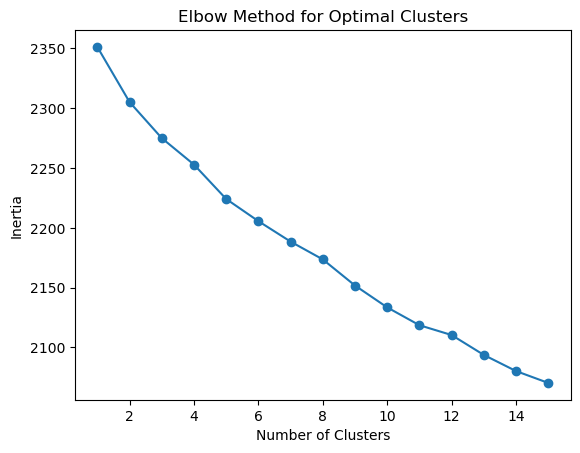

In [6]:
# Helper function to preprocess text data
def preprocess_text(texts):
    vectorizer = TfidfVectorizer(max_features=2500, stop_words='english')
    X = vectorizer.fit_transform(texts)
    return X

# Helper function to find the optimal number of clusters using the Elbow Method
def find_optimal_clusters(X, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    return inertias

# Preprocess training texts
train_X = preprocess_text(train_texts)

# Find optimal number of clusters using the Elbow Method
max_clusters = 15
inertias = find_optimal_clusters(train_X, max_clusters)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show

In [7]:
# Perform K-Means clustering
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=10)
train_clusters = kmeans.fit_predict(train_X)

# Identify the most common words in each cluster
def get_most_common_words_in_cluster(cluster, top_n=10):
    cluster_texts = [train_texts[i] for i in range(len(train_texts)) if train_clusters[i] == cluster]
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(cluster_texts)
    tfidf_sum = np.array(X.sum(axis=0)).squeeze()
    feature_names = np.array(vectorizer.get_feature_names_out())  # Corrected attribute name
    sorted_indices = np.argsort(tfidf_sum)[::-1]
    most_common_words = feature_names[sorted_indices][:top_n]
    return most_common_words

# Print the most common words in each cluster
for cluster in range(num_clusters):
    most_common_words = get_most_common_words_in_cluster(cluster)
    print(f"Cluster {cluster}: {', '.join(most_common_words)}")

Cluster 0: said, china, wang, beijing, chinese, taiwan, year, trade, foreign, percent
Cluster 1: said, company, market, percent, new, billion, million, year, bank, amp
Cluster 2: hong, kong, said, china, tung, beijing, legislature, chinese, committee, people
Cluster 3: gm, said, workers, uaw, plants, plant, strike, local, parts, union
Cluster 4: said, internet, apple, quarter, microsoft, software, computer, company, new, year
Cluster 5: said, gold, bre, toronto, shares, percent, barrick, million, market, index
Cluster 6: oil, said, russia, russian, tonnes, output, million, percent, year, prices
Cluster 7: said, million, percent, year, sales, quarter, pounds, billion, company, profits


Cluster 0: Authors: AaronPressman, EricAuchard, KirstinRidley, KouroshKarimkhany, NickLouth, RogerFillion, SamuelPerry, TheresePoletti
Cluster 0: Most Common Words: said, new, company, corp, internet, market, year, percent, computer, quarter

Cluster 1: Authors: AlexanderSmith, BernardHickey, BradDorfman, DarrenSchuettler, DavidLawder, EdnaFernandes, FumikoFujisaki, HeatherScoffield, JoeOrtiz, JonathanBirt, JoWinterbottom, KarlPenhaul, KeithWeir, KevinDrawbaugh, KevinMorrison, LydiaZajc, LynnleyBrowning, MarcelMichelson, MarkBendeich, MartinWolk, MatthewBunce, MichaelConnor, PatriciaCommins, PierreTran, RobinSidel, SimonCowell, TimFarrand, ToddNissen
Cluster 1: Most Common Words: said, million, percent, year, company, billion, pounds, new, market, group

Cluster 2: Authors: AlanCrosby, JanLopatka, JohnMastrini
Cluster 2: Most Common Words: said, czech, percent, year, klaus, market, prague, bank, billion, government

Cluster 3: Authors: BenjaminKangLim, GrahamEarnshaw, JaneMacartney, Ji

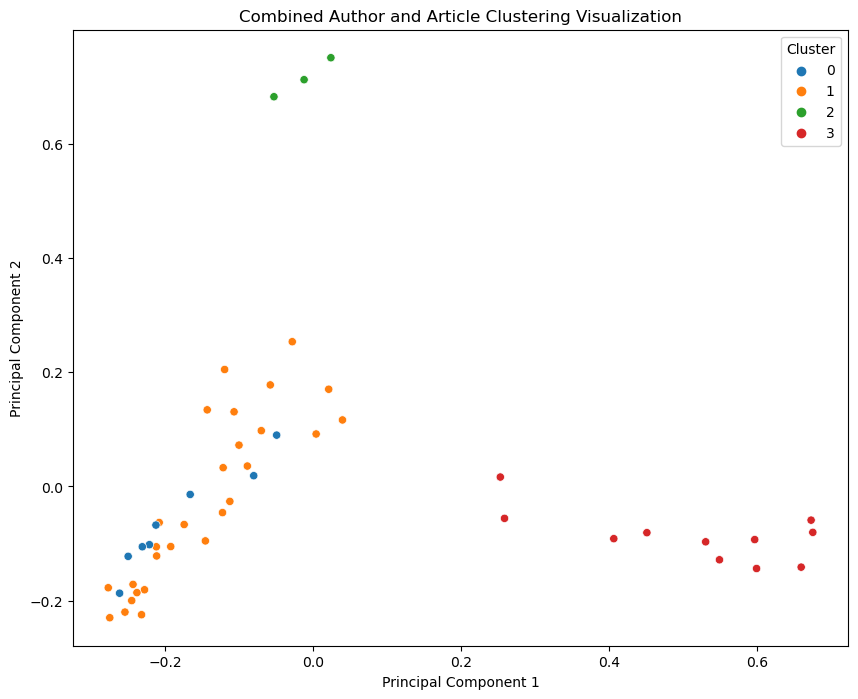

In [8]:
# Get author labels
train_author_labels = train_labels  # Assuming train_labels contains author names

# Combine articles by the same author
combined_train_texts = defaultdict(str)
for i, author in enumerate(train_author_labels):
    combined_train_texts[author] += train_texts[i]

# Create a DataFrame with authors and combined texts
combined_train_data = pd.DataFrame({'Author': list(combined_train_texts.keys()), 'Text': list(combined_train_texts.values())})

# Preprocess combined texts for authors
combined_train_X = preprocess_text(combined_train_data['Text'])

# Apply dimensionality reduction for visualization
pca = PCA(n_components=2)
combined_train_X_pca = pca.fit_transform(combined_train_X.toarray())

# Perform K-Means clustering on combined authors
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=10)
combined_clusters = kmeans.fit_predict(combined_train_X)

# Add cluster labels to the DataFrame
combined_train_data['Cluster'] = combined_clusters

# Print authors within each cluster
for cluster in range(num_clusters):
    cluster_authors = combined_train_data[combined_train_data['Cluster'] == cluster]['Author']
    print(f"Cluster {cluster}: Authors: {', '.join(cluster_authors)}")

    # Identify the most common words in each cluster
    cluster_texts = combined_train_data[combined_train_data['Cluster'] == cluster]['Text']
    vectorizer = TfidfVectorizer(stop_words='english')
    cluster_X = vectorizer.fit_transform(cluster_texts)
    tfidf_sum = np.array(cluster_X.sum(axis=0)).squeeze()
    feature_names = np.array(vectorizer.get_feature_names_out())
    sorted_indices = np.argsort(tfidf_sum)[::-1]
    most_common_words = feature_names[sorted_indices][:10]
    print(f"Cluster {cluster}: Most Common Words: {', '.join(most_common_words)}")
    print()

# Create a scatter plot with color-coded clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=combined_train_X_pca[:, 0], y=combined_train_X_pca[:, 1], hue=combined_clusters, palette='tab10')
plt.title('Combined Author and Article Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

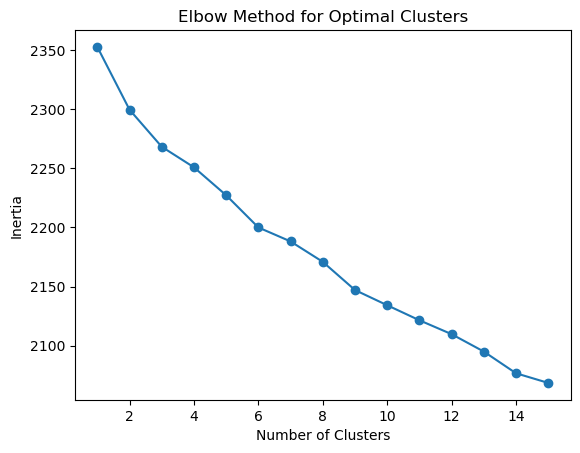

In [9]:
# Helper function to preprocess text data
def preprocess_text(texts):
    vectorizer = TfidfVectorizer(max_features=2500, stop_words='english')
    X = vectorizer.fit_transform(texts)
    return X

# Helper function to find the optimal number of clusters using the Elbow Method
def find_optimal_clusters(X, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    return inertias

#Preprocess test texts
test_X = preprocess_text(test_texts)

# Find optimal number of clusters using the Elbow Method
max_clusters = 15
inertias = find_optimal_clusters(test_X, max_clusters)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show

Cluster 0: Authors: AlexanderSmith, EdnaFernandes, JoeOrtiz, JonathanBirt, JoWinterbottom, KeithWeir, KirstinRidley, SimonCowell, TimFarrand
Cluster 0: Most Common Words: said, million, percent, pounds, year, company, market, british, group, billion

Cluster 1: Authors: BenjaminKangLim, GrahamEarnshaw, JaneMacartney, LynneO'Donnell, MureDickie, PeterHumphrey, SarahDavison, ScottHillis, TanEeLyn, WilliamKazer
Cluster 1: Most Common Words: said, china, kong, hong, chinese, beijing, year, deng, people, state

Cluster 2: Authors: AaronPressman, BernardHickey, BradDorfman, DarrenSchuettler, DavidLawder, EricAuchard, FumikoFujisaki, HeatherScoffield, JimGilchrist, KarlPenhaul, KevinDrawbaugh, KevinMorrison, KouroshKarimkhany, LydiaZajc, LynnleyBrowning, MarcelMichelson, MarkBendeich, MartinWolk, MatthewBunce, MichaelConnor, NickLouth, PatriciaCommins, PierreTran, RobinSidel, RogerFillion, SamuelPerry, TheresePoletti, ToddNissen
Cluster 2: Most Common Words: said, percent, million, year, comp

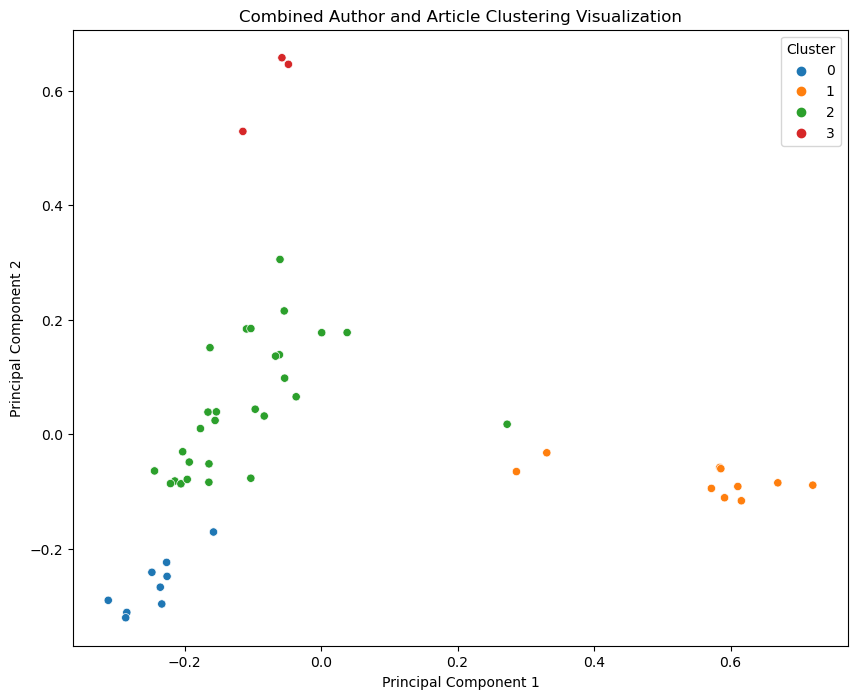

In [11]:
# Get author labels
test_author_labels = test_labels  # Assuming train_labels contains author names

# Combine articles by the same author
combined_test_texts = defaultdict(str)
for i, author in enumerate(test_author_labels):
    combined_test_texts[author] += test_texts[i]

# Create a DataFrame with authors and combined texts
combined_test_data = pd.DataFrame({'Author': list(combined_test_texts.keys()), 'Text': list(combined_test_texts.values())})

# Preprocess combined texts for authors
combined_test_X = preprocess_text(combined_test_data['Text'])

# Apply dimensionality reduction for visualization
pca = PCA(n_components=2)
combined_test_X_pca = pca.fit_transform(combined_test_X.toarray())

# Perform K-Means clustering on combined authors
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=10)
combined_clusters = kmeans.fit_predict(combined_test_X)

# Add cluster labels to the DataFrame
combined_test_data['Cluster'] = combined_clusters

# Print authors within each cluster
for cluster in range(num_clusters):
    cluster_authors = combined_test_data[combined_test_data['Cluster'] == cluster]['Author']
    print(f"Cluster {cluster}: Authors: {', '.join(cluster_authors)}")

    # Identify the most common words in each cluster
    cluster_texts = combined_test_data[combined_test_data['Cluster'] == cluster]['Text']
    vectorizer = TfidfVectorizer(stop_words='english')
    cluster_X = vectorizer.fit_transform(cluster_texts)
    tfidf_sum = np.array(cluster_X.sum(axis=0)).squeeze()
    feature_names = np.array(vectorizer.get_feature_names_out())
    sorted_indices = np.argsort(tfidf_sum)[::-1]
    most_common_words = feature_names[sorted_indices][:10]
    print(f"Cluster {cluster}: Most Common Words: {', '.join(most_common_words)}")
    print()

# Create a scatter plot with color-coded clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=combined_test_X_pca[:, 0], y=combined_test_X_pca[:, 1], hue=combined_clusters, palette='tab10')
plt.title('Combined Author and Article Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Question

Between the 50 authors and their respective 50 stories in both the training set and test set, we wanted to know what similarities we could find between authors and the type of articles they write through utilizing clustering.

### Approach

For the initial EDA of all the texts, we decided to use some of Professors' James code provided for us students to start the exercise. In doing so, we discovered that some of the most common words used were "year", "company", "would", "percent", "million", and "market" in that descending order. Upon an initial look, we assumed many of these articles would be about businesses or companies and perhaps their growth over the years, or revenue gathered. 

To see if that hypothesis was true, we began our kmeans clustering by utilizing the elbow method. We saw that at 4 and at 8 clusters was where the elbow point could be and decided to run the kmeans with 8 to get an image of what words were being clustered together. We were seeing clusters of different technologies, countries, and more words related to businesses or companies. Seeing clusters that were too similar, however, such as having China be a common word in both clusters 0 and 2, we ultimately decided to go with k=4 instead for our clustering.

Our next step was creating a dataframe to combine authors with their texts so we could have a better idea of how article words and authors were correlated. The main idea was to see how authors may be similar in writing about a specific country, technology, or something else entirely. With the new dataframe, we did our clustering on the training set and repeated the entirely process from beginning to end on the test set for comparison.

### Results

Comparing the results of clustered authors and words we achieved between both the training and testing sets of articles, they appear nearly identical. At 4 clusters, each of them provided very similar graphs and the most common words were practically the same. One cluster was focused on china, hong kong, and other foreign matters. Another was focused on Czech, Prague, and government. A third cluster that had the majority of the authors focused on numerical values in the millions (and billions), companies, and markets.

One combination of clusters, however, did end up being different. While there's a cluster on the training set that has common words such as computer and technology, a cluster in the test set makes mention of pounds and british instead. In this case, while some authors are the same between them, there are others that were placed into other clusters instead.

### Conclusion

Between the two sets of articles given to us, we were indeed able to find some similaries between authors, not to mention be able to make some assumptions on some authors. For example, The majority of these authors appear to write often about markets and monetary values. Their writing isn't necessarily centered around a single market, but seem to stretch into Europe and Asia as well. These authors appear to be consistent in their topics as well, given the similarities of common words and author placement into clusters between the two sets. As mentioned in the results, there are some outlying authors who switched clusters but that's to be expected since some clusters are extremely identical in their common words shared. This is likely due to many of them being related to business as a whole, an idea ascertained through our EDA. 

What surprised us most was the consistency of authors that wrote about China. We actually tried various other counts of clusters as well, and China almost always popped up in 2 or more clusters. This could be due to China being such a large manufacturing nation in the current day and day. Given such, it would be impossible to ignore the large impact the country has in the business world and markets worldwide, and it appears some authors in our data understand exactly that.